Adrian-Nichita Zloteanu  
MSCS-634  
Lab 6: Market Basket Analysis with Instacart Dataset

# Loading the dataset

For this exercise, I will use the Instacart dataset from Kaggle, and clean it up a bit by dropping missing values, duplicates, etc. 

I am only loading the products and order_products_prior CSVs (and those are the ones I've included in the repo) since they're the only ones I need for this assignment.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load CSV files from the instacart folder
order_products = pd.read_csv('instacart/order_products__prior.csv')
products = pd.read_csv('instacart/products.csv')

# merge them to get product names with order details
merged = order_products.merge(products, on='product_id', how='left')

# clean up the data: drop missing values and duplicates
merged = merged.dropna().drop_duplicates()

display(merged.head())

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


Now I will show the most commonly purchased items using a barplot, and create a co-occurence heatmap of top purchased items

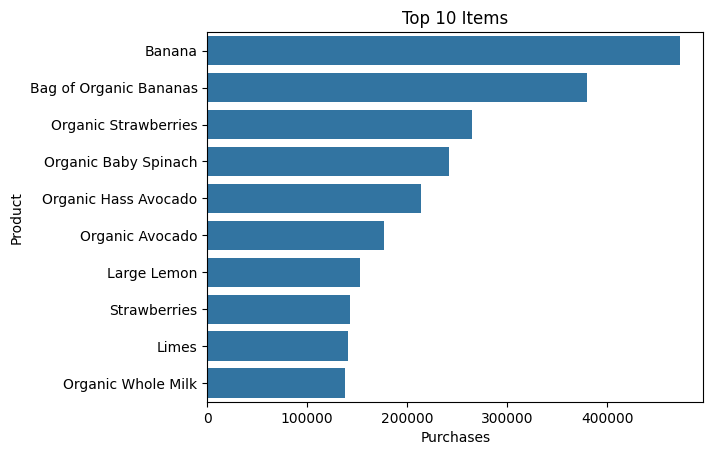

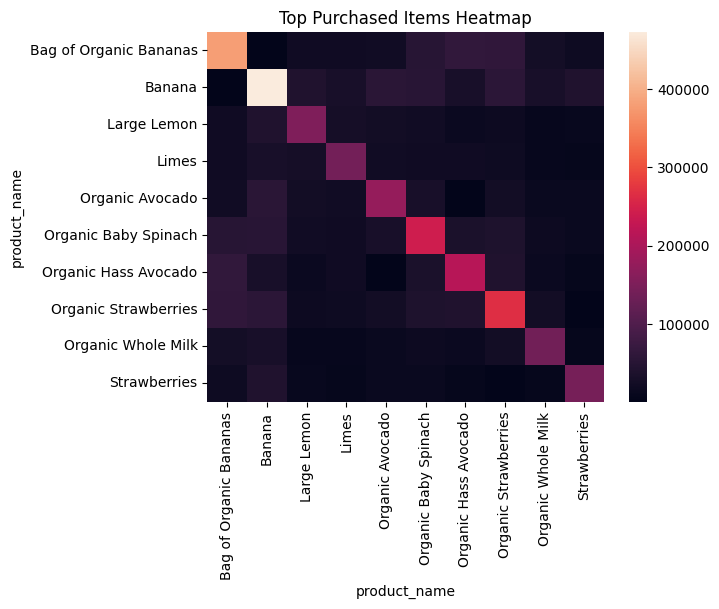

In [18]:
item_counts = merged['product_name'].value_counts().head(10)
sns.barplot(x=item_counts.values, y=item_counts.index)
plt.title('Top 10 Items')
plt.xlabel('Purchases')
plt.ylabel('Product')
plt.show()

# now let's create a co-occurrence matrix for the top 10 items
top_items = item_counts.index.tolist()
basket = merged[merged['product_name'].isin(top_items)].groupby(['order_id', 'product_name'])['product_name'].count().unstack().fillna(0)
co_matrix = basket.T.dot(basket) # create the matrix
sns.heatmap(co_matrix)
plt.title('Top Purchased Items Heatmap')
plt.show()

# Frequent Itemset Mining Using Apriori
Now, I will load the apriori algorithm from the mlxtend library and use it to find frequent itemsets.

Apriori was crashing my jupyter notebook when running for all products, so I am limiting it to 20 for the purposes of this lab. Due to that, I will be using a support threshold of 0.01, which should work well since i'm using the most popular products anyway.

I will display the itemsets together with their support values:

,support,itemsets
2,0.272664,(Banana)
1,0.218938,(Bag of Organic Bananas)
15,0.152719,(Organic Strawberries)
7,0.139585,(Organic Baby Spinach)
12,0.123235,(Organic Hass Avocado)
6,0.102020,(Organic Avocado)
4,0.088081,(Large Lemon)
19,0.082481,(Strawberries)
5,0.081140,(Limes)
16,0.079569,(Organic Whole Milk)


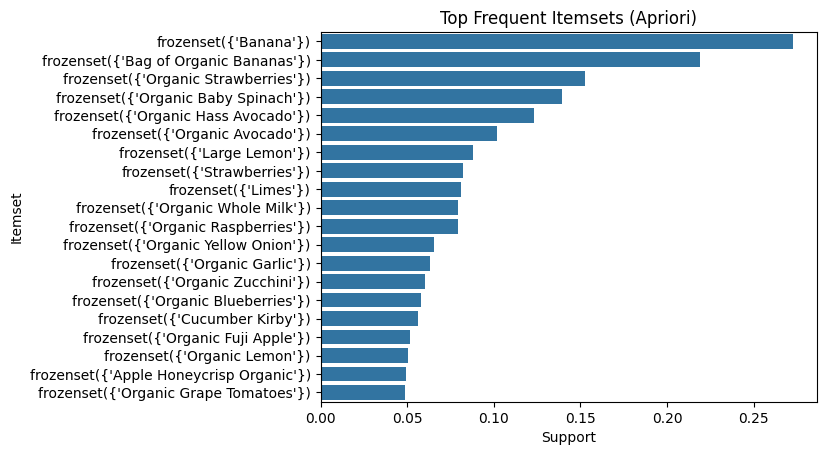

In [ ]:
from mlxtend.frequent_patterns import apriori

# limit to top 20 products to avoid memory issues
N = 20
top_products = merged['product_name'].value_counts().head(N).index.tolist()
filtered = merged[merged['product_name'].isin(top_products)]

# prepare basket data for Apriori
basket_apriori = (
    filtered
    .groupby(['order_id', 'product_name'])['product_name']
    .count()
    .unstack()
    .fillna(0)
    .astype(bool) 
)

# run it
frequent_itemsets = apriori(basket_apriori, min_support=0.01, use_colnames=True)

# display the top frequent itemsets
display(frequent_itemsets.sort_values('support', ascending=False).head(10))

# and vizualize them
sns.barplot(
    x=frequent_itemsets.sort_values('support', ascending=False).head(N)['support'],
    y=frequent_itemsets.sort_values('support', ascending=False).head(N)['itemsets'].astype(str)
)
plt.title('Apriori')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()

# FP-Growth
Now we'll use FP-Growth for the same purpose, and compare the efficiency to Apriori:

,support,itemsets
4,0.272664,(Banana)
1,0.218938,(Bag of Organic Bananas)
5,0.152719,(Organic Strawberries)
0,0.139585,(Organic Baby Spinach)
2,0.123235,(Organic Hass Avocado)
6,0.102020,(Organic Avocado)
8,0.088081,(Large Lemon)
12,0.082481,(Strawberries)
17,0.081140,(Limes)
7,0.079569,(Organic Whole Milk)


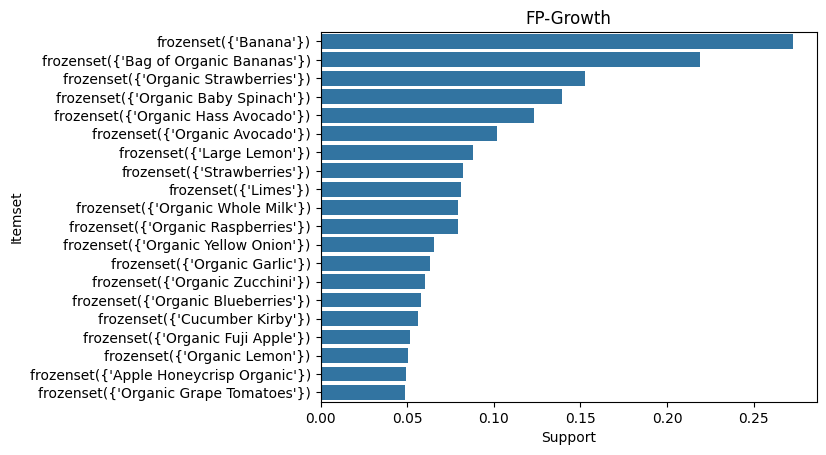

Apriori found 75 itemsets, FP-Growth found 75 itemsets.


In [24]:
from mlxtend.frequent_patterns import fpgrowth

# same basket and support as before
fp_frequent_itemsets = fpgrowth(basket_apriori, min_support=0.01, use_colnames=True)

# display top frequent itemsets and support
display(fp_frequent_itemsets.sort_values('support', ascending=False).head(10))

# visualise in a barplot
sns.barplot(
    x=fp_frequent_itemsets.sort_values('support', ascending=False).head(N)['support'],
    y=fp_frequent_itemsets.sort_values('support', ascending=False).head(N)['itemsets'].astype(str)
)
plt.title('FP-Growth')
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.show()

# print comparison of the two methods
print(f"Apriori found {len(frequent_itemsets)} itemsets, FP-Growth found {len(fp_frequent_itemsets)} itemsets.")

# Association rules

Now I will generate association rules for both algorithms, using a confidence threshold of 0.3. I'll include support, confidence and lift to the visualisations:

,antecedents,consequents,support,confidence,lift
2,(Organic Fuji Apple),(Banana),0.019585,0.378693,1.388865
0,(Cucumber Kirby),(Banana),0.018520,0.329826,1.209644
1,(Organic Avocado),(Banana),0.030808,0.301982,1.107527


,antecedents,consequents,support,confidence,lift
2,(Organic Fuji Apple),(Banana),0.019585,0.378693,1.388865
1,(Cucumber Kirby),(Banana),0.018520,0.329826,1.209644
0,(Organic Avocado),(Banana),0.030808,0.301982,1.107527


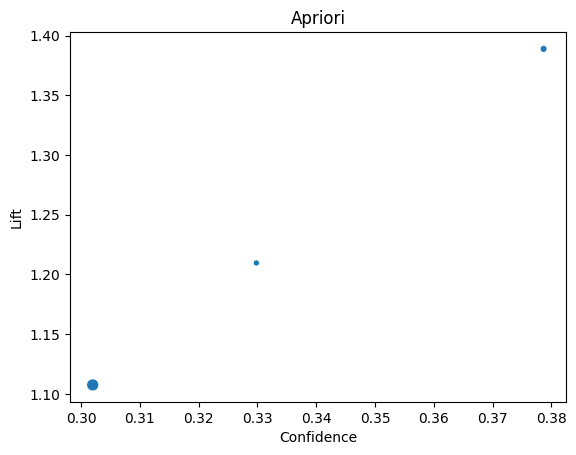

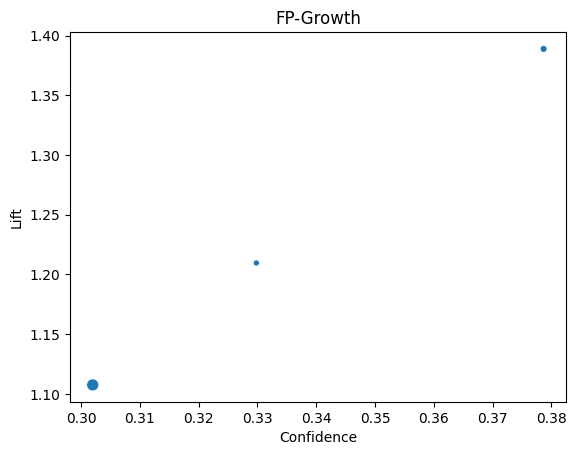

In [25]:
from mlxtend.frequent_patterns import association_rules

confidence_threshold = 0.3

# association rules:
rules_apriori = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_threshold)
rules_fpgrowth = association_rules(fp_frequent_itemsets, metric="confidence", min_threshold=confidence_threshold)

# display top rules by lift
display(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10))
display(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10))

# visualise confidence vs lift for both:
sns.scatterplot(x=rules_apriori['confidence'], y=rules_apriori['lift'], size=rules_apriori['support'], legend=False)
plt.title('Apriori')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()

sns.scatterplot(x=rules_fpgrowth['confidence'], y=rules_fpgrowth['lift'], size=rules_fpgrowth['support'], legend=False)
plt.title('FP-Growth')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()

# Insights

The rule Organic Fuji Apple → Banana showed a very strong support of approximately 0.0196, indicating that this item pair appears in nearly 2% of transactions. It also has the highest confidence at 0.3787 and a lift of 1.39, suggesting a strong association between these items—customers who buy Organic Fuji Apples are way more likely to also buy Bananas.

The scatter plots of confidence vs lift visualise the strength of the rules generated by both algorithms: the points with the highest confidence also showed the highest lift, showing that these are reliable associations. 

The fact that both apriori and fpgrowth yielded identical results, further confirms the consistency of the findings. Such insights can be useful for product recommendations, cross-promotions, or store ayout decisions, though ideally the calculations would be done on a larger N provided the appropriate processing power is available.

# Analysis

Interestingly, both apriori and fpgrowth produced the same frequent itemsets and association rules when applied with N=20. Items such as Bananas, both single and in a bag, and organic strawberries all showed high support across both methods. This shows that while the two algorithms differ in their approach, running them on the same data with the same threshold can lead equivalent results.

FPGrowth was, however, significantly faster to run than apriori. This is due to fpgrowths's implementation: building the FP-Tree allows it to mine frequent pattenrs without scanning the dataset or generating a large number of candidate itemsets. Since apriori requires multiple dataset passes, it becomes extremely expensive as the itemset size growth (such as in the Instacart case). This made it much slower in practice.

The main challenge I faced was the Jupyter kernel repeatedly crashing during the Apriori computations. This was likely due to very high memory usage when processing the full dataset, which my laptop could not handle. To resolve this, I limited the analysis to only the top 20 most frequently purchased products. This reduced the size of the basket matrix, allowing both Apriori and FP-Growth to run successfully without further crashes.